<a href="https://colab.research.google.com/github/Fileboss/BAUS_Database_Midterm_Assignement/blob/main/INHA_BAUS_Database_Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAUS Philippe - 12224893
# DATABASE
## MIDTERM ASSIGNEMENT

## 1 - Data Model

To model this system, I used the Looping software (https://www.looping-mcd.fr/) which is a free database modeling software easy to use. I decided to use it because I already knew it from my University in France. Looping is free to use and avaible on Windows computer. I will provide my Looping source file in the assignement archive.

I will detail in this report the different choices I made.

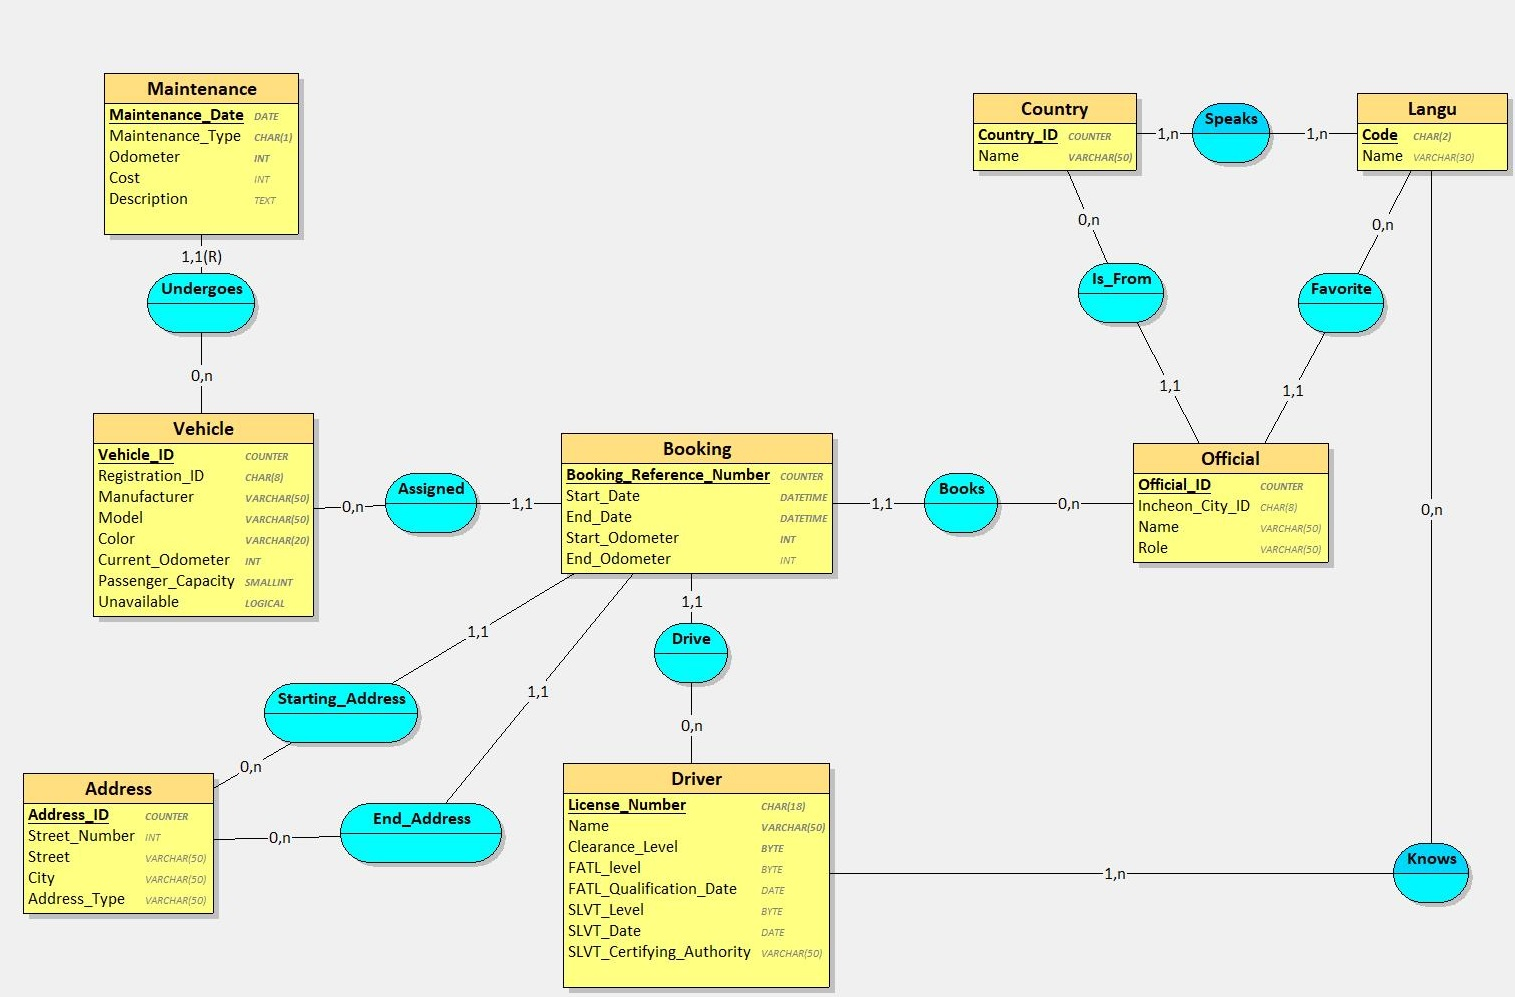

To create this model, I did a careful reading of the subject, during which I noted and grouped the data into families. Then I tried to draw the links between the entity classes. Finally, I deduced their cardinalities.

## 2 - Creating the database with scripts

In [1]:
from sqlalchemy import create_engine
my_conn = create_engine("sqlite:////content/my_db2.db")
conn = my_conn.connect()

### Vehicle Table

Every field is non-nullable. I decided to add a constraint to prevent adding two cars in the system with the same registration_ID.
Note that the unavaible flag should not be used to indicate if a car has already been booked or not, but only to indicate that a car is unavailable for some reason (for exemple if it is not orking)

In [2]:
my_conn.execute('''CREATE TABLE Vehicle(
    Vehicle_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Registration_ID CHAR(8) NOT NULL,
    Manufacturer VARCHAR(50) NOT NULL,
    Model VARCHAR(50) NOT NULL,
    Color VARCHAR(20) NOT NULL,
    Current_Odometer INT NOT NULL,
    Passenger_Capacity SMALLINT NOT NULL,
    Unavailable BOOLEAN NOT NULL CHECK (Unavailable IN (0, 1)),
    CONSTRAINT UNQ_Registration_ID UNIQUE(Registration_ID)
  );''')

### Maintenance Table

In this table, I added a constraint to check if the maintenance type is only 'M' or 'R'.
I decided that the desciption might be empty.

In [3]:
my_conn.execute('''CREATE TABLE Maintenance(
   Vehicle_ID INT,
   Maintenance_Date DATE,
   Maintenance_Type CHAR(1) NOT NULL,
   Odometer INT NOT NULL,
   Cost INT NOT NULL,
   Description TEXT,
   PRIMARY KEY(Vehicle_ID, Maintenance_Date),
   FOREIGN KEY(Vehicle_ID) REFERENCES Vehicle(Vehicle_ID),
   CONSTRAINT CHK_Maintenance_Type CHECK (Maintenance_Type='M' OR Maintenance_Type='R')
);''')

### Country Table

This table stores the Countries. A country is reprensented by a Name an an unique ID

In [4]:
my_conn.execute('''CREATE TABLE Country(
   Country_ID INTEGER PRIMARY KEY AUTOINCREMENT,
   Name VARCHAR(50) NOT NULL
);''')

### Langu Table

I decided to use 'Langu' as the name of this table because 'Language' is a reserved word in SQL. This table stores the languages stored in the system.

In [5]:
my_conn.execute('''CREATE TABLE Langu(
   Code CHAR(2),
   Name VARCHAR(30),
   PRIMARY KEY(Code)
);''')

### Official Table

This table contains the Official's information. The information about its Country and spoken language are respectively refferences to a Country_ID and to a Langu Code.

In [6]:
my_conn.execute('''CREATE TABLE Official(
    Official_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Incheon_City_ID CHAR(8) NOT NULL,
    Name VARCHAR(50) NOT NULL,
    Role VARCHAR(50) NOT NULL,
    Country_ID INT NOT NULL,
    Code CHAR(2) NOT NULL,
    FOREIGN KEY(Country_ID) REFERENCES Country(Country_ID),
    FOREIGN KEY(Code) REFERENCES Langu(Code)
  );''')

### Driver Table

This table will contains the information related to drivers. I decided not to create specific table for SLVT and FATL. However, I will have to use a constraints to check the consistancy of data, because, for example if the FATL_lvl has a value, then it is required for the field FATL_Qualification_Date to also have a value.

I added a total of 5 constraint to this table.

*   CHK_Clearance_Level CHECK : created in order to ensure 0 < Clearance_level < 5
*   CHK_FATL_Level : created in order to ensure 0 < FATL_level < 6
*   CHK_SLVT_Level : created in order to ensure 0 < SLVT_level < 11
*   CHK_FATL_level_Qualification_Date_Synchronized : created to ensure that every fields related to FATL are all filled at the same time or all null at the same time
*   CONSTRAINT CHK_SLVT_level_Date_Certifying_Synchronized : created to ensure that every fields related to SLVT are all filled at the same time or all null at the same time



In [7]:
my_conn.execute('''CREATE TABLE Driver(
    License_Number CHAR(18),
    Name VARCHAR(50) NOT NULL,
    Clearance_Level BYTE NOT NULL,
    FATL_level BYTE,
    FATL_Qualification_Date DATE,
    SLVT_Level BYTE,
    SLVT_Date DATE,
    SLVT_Certifying_Authority VARCHAR(50),
    PRIMARY KEY(License_Number),
    CONSTRAINT CHK_Clearance_Level CHECK (Clearance_Level > 0 AND Clearance_Level < 5),
    CONSTRAINT CHK_FATL_Level CHECK (FATL_level > 0 AND FATL_level < 11),
    CONSTRAINT CHK_SLVT_Level CHECK (SLVT_level > 0 AND SLVT_level < 6),
    CONSTRAINT CHK_FATL_level_Qualification_Date_Synchronized 
          CHECK (   (FATL_level IS NULL AND FATL_Qualification_Date IS NULL) 
                OR (FATL_level IS NOT NULL AND FATL_Qualification_Date IS NOT NULL)),
      CONSTRAINT CHK_SLVT_level_Date_Certifying_Synchronized 
          CHECK (   (SLVT_level IS NULL AND SLVT_DATE IS NULL AND SLVT_Certifying_Authority IS NULL) 
                OR (SLVT_level IS NOT NULL AND SLVT_DATE IS NOT NULL AND SLVT_Certifying_Authority IS NOT NULL))
  );''')

### Address Table

I decided to create an Address table, because a Booking uses a Starting Address and an Ending Address. By creating a table, the model is lighter and more convenient.

In [8]:
my_conn.execute('''CREATE TABLE Address(
   Address_ID INTEGER PRIMARY KEY AUTOINCREMENT,
   Street_Number INT NOT NULL,
   Street VARCHAR(50) NOT NULL,
   City VARCHAR(50) NOT NULL,
   Address_Type VARCHAR(50) NOT NULL,
   CONSTRAINT UNQ_Address UNIQUE (Street_Number, Street, City)
);''')

### Booking Table

This table contains the Booking information. As mentioned before, Starting_Address and Ending_Address are references to the Address table.

In [9]:
my_conn.execute('''  CREATE TABLE Booking(
    Booking_Reference_Number INTEGER PRIMARY KEY AUTOINCREMENT,
    Start_Date DATETIME NOT NULL,
    End_Date DATETIME NOT NULL,
    Start_Odometer INT NOT NULL,
    End_Odometer INT NOT NULL,
    Starting_Address INT NOT NULL,
    Ending_Address INT NOT NULL,
    Vehicle_ID INTEGER NOT NULL,
    License_Number CHAR(18) NOT NULL,
    Official_ID INT NOT NULL,
    FOREIGN KEY(Starting_Address) REFERENCES Address(Address_ID),
    FOREIGN KEY(Ending_Address) REFERENCES Address(Address_ID),
    FOREIGN KEY(Vehicle_ID) REFERENCES Vehicle(Vehicle_ID),
    FOREIGN KEY(License_Number) REFERENCES Driver(License_Number),
    FOREIGN KEY(Official_ID) REFERENCES Official(Official_ID)
  );''')

### Speaks Table (n-n Relationship)

A n-n relationship actually is a table that shows the relationship between two foreign keys. Here for example, the Speaks table contains every relationship that links a Country and a Language. A country can have multiple spoken languages, and a Language can be spoken in multiple countries.

In [10]:
my_conn.execute('''CREATE TABLE Speaks(
   Country_ID INT,
   Code CHAR(2),
   PRIMARY KEY(Country_ID, Code),
   FOREIGN KEY(Country_ID) REFERENCES Country(Country_ID),
   FOREIGN KEY(Code) REFERENCES Langu(Code)
);''')

### Knows Table (n-n Relationship)

In [11]:
my_conn.execute('''CREATE TABLE Knows(
   Code CHAR(2),
   License_Number CHAR(18),
   PRIMARY KEY(Code, License_Number),
   FOREIGN KEY(Code) REFERENCES Langu(Code),
   FOREIGN KEY(License_Number) REFERENCES Driver(License_Number)
);''')

### Request the databse to see if every table has correctly been created

In [12]:
r_set = my_conn.execute('''select name from sqlite_master 
  where type = 'table' ''')
for row in r_set:
  print(row)

('Vehicle',)
('sqlite_sequence',)
('Maintenance',)
('Country',)
('Langu',)
('Official',)
('Driver',)
('Address',)
('Booking',)
('Speaks',)
('Knows',)


Here we can see that every Table has correctly be created in the database

### Triggers

It is necessary to create triggers to prevent the insertion of inconsistent data into the database

This trigger prevent from inserting a Booking referencing a driver who is already busy during the Booking period. Indeed, a driver can not be booked twice at the same moment.

In [13]:
my_conn.execute('''
CREATE TRIGGER IF NOT EXISTS TRG_Booking_Driver_Time_Overlap
BEFORE INSERT
ON Booking
FOR EACH ROW    
WHEN (( SELECT COUNT(*)
        FROM Booking, Driver
        WHERE Booking.License_Number = Driver.License_Number
        AND Booking.License_Number = NEW.License_Number
        AND NEW.End_Date > Booking.Start_Date
        AND NEW.Start_Date < Booking.End_Date)) > 0
BEGIN
        SELECT RAISE(ABORT, 'Driver is not available during this time');
END;''')

Same goes for the vehicles

In [14]:
my_conn.execute('''CREATE TRIGGER IF NOT EXISTS TRG_Booking_Vehicle_Time_Overlap
BEFORE INSERT
ON Booking
FOR EACH ROW
WHEN (( SELECT COUNT(*)
        FROM Booking, Vehicle
        WHERE Booking.Vehicle_ID = Vehicle.Vehicle_ID
        AND Booking.Vehicle_ID = NEW.Vehicle_ID
        AND NEW.End_Date > Booking.Start_Date
        AND NEW.Start_Date < Booking.End_Date)) > 0
BEGIN
        SELECT RAISE(ABORT, 'Vehicle is not available during this time');
END;''')

Same goes for the officials

In [15]:
my_conn.execute('''CREATE TRIGGER IF NOT EXISTS TRG_Booking_Official_Time_Overlap
BEFORE INSERT
ON Booking
FOR EACH ROW
WHEN (( SELECT COUNT(*)
        FROM Booking, Official
        WHERE Booking.Official_ID = Official.Official_ID
        AND Booking.Official_ID = NEW.Official_ID
        AND NEW.End_Date > Booking.Start_Date
        AND NEW.Start_Date < Booking.End_Date) > 0)
BEGIN
        SELECT RAISE(ABORT, 'Official already has a booking during this time');
END;''')

## 3 - Inserting Data

To insert data, I use INSERT INTO sql request. My requests are stored online using the pastbin website. Then I use Python to read this file and execute all the queries.
The file is available here : https://pastebin.com/raw/dzeNiyfA

In [16]:
import requests

In [17]:
url = 'https://pastebin.com/raw/dzeNiyfA'
r = requests.get(url)
queries = r.text
print (type(queries))
queries_lines = queries.splitlines()
for query in queries_lines:
   my_conn.execute(query)

<class 'str'>


**Retreiving data:**

To show that the data has correctly been imported, I perform a SELECT * on every tables :

In [18]:
query = "SELECT * FROM Driver"
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

('12345678901234567', 'Patrick Bienvenue', 1, 1, '2010-01-01', 1, '2010-01-01', 'Seoul Police Department')
('12345678901234568', 'Park Cheu Yung', 2, 2, '2010-02-01', 2, '2010-02-01', 'Incheon City')
('12345678901234569', 'Mike Horn', 3, None, None, 3, '2010-03-01', 'Incheon City')
('12345678901234570', 'Pierre Valentin', 4, 4, '2010-04-01', None, None, None)


In [19]:
query = "SELECT * FROM Vehicle"
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

(1, 'ABC1234', 'Toyota', 'Corolla', 'Red', 10000, 5, 0)
(2, 'ABC1235', 'Pontiac', 'Firebird', 'Blue', 20000, 2, 0)
(3, 'ABC1236', 'Ford', 'Mustang', 'Black', 30000, 2, 0)
(4, 'ABC1237', 'Honda', 'Civic', 'White', 40000, 5, 1)


In [20]:
query = "SELECT * FROM Maintenance"
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

(1, '2010-01-01', 'M', 8000, 100, 'Oil Change')
(2, '2010-02-01', 'M', 18000, 200, 'Tire Rotation')


In [21]:
query = "SELECT * FROM Country"
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

(1, 'Canada')
(2, 'United States')
(3, 'Mexico')
(4, 'France')


In [22]:
query = "SELECT * FROM Langu"
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

('EN', 'English')
('FR', 'French')
('ES', 'Spanish')


In [23]:
query = "SELECT * FROM Official"
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

(1, '12345678', 'John Smith', 'Mayor', 1, 'EN')
(2, '12345679', 'Patrick Sebastien', 'Deputy Mayor', 2, 'EN')
(3, '12345680', 'Juan Perez', 'Mayor', 3, 'ES')
(4, '12345681', 'Jean Dupont', 'Mayor', 4, 'FR')


In [24]:
query = "SELECT * FROM Address"
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

(1, 123, 'Main Street', 'Incheon', 'Home')
(2, 456, '2nd street', 'Incheon', 'Work')
(3, 789, 'Main Plaza', 'Seoul', 'Hotel')
(4, 101, '1st street', 'Seoul', 'Work')


In [25]:
query = "SELECT * FROM Booking"
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

(1, '2010-01-01 10:30:00', '2010-01-02 07:00:00', 10000, 11000, 1, 2, 1, '12345678901234567', 2)


In [26]:
query = "SELECT * FROM Knows"
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

('EN', '12345678901234567')
('EN', '12345678901234568')
('EN', '12345678901234569')
('EN', '12345678901234570')
('FR', '12345678901234570')


In [27]:
query = "SELECT * FROM Speaks"
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

(1, 'EN')
(2, 'EN')
(3, 'ES')
(4, 'FR')


###4 - More complex queries examples

We can imagine that this database will be integrated into an application allowing the management of reservations. To do this, the application will need to perform more complex queries than a 'SELECT *'.
Here are some examples of queries that could be performed.

Find all Drivers who speaks English

In [ ]:
query = ('''SELECT d.License_Number, d.Name, l.Code FROM Driver d, Langu l, Knows k
WHERE k.License_Number = d.License_Number
AND k.Code = l.Code
AND l.Code = 'EN'; ''')
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

('12345678901234567', 'Patrick Bienvenue', 'EN')
('12345678901234568', 'Park Cheu Yung', 'EN')
('12345678901234569', 'Mike Horn', 'EN')
('12345678901234570', 'Pierre Valentin', 'EN')


Find a car which has not been tagged as unavailable.

In [ ]:
query = ('''SELECT v.Registration_ID, v.Manufacturer, v.Model, v.Color, v.Current_Odometer, v.Passenger_Capacity
FROM Vehicle v
WHERE v.Unavailable = 0;''')
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

('ABC1234', 'Toyota', 'Corolla', 'Red', 10000, 5)
('ABC1235', 'Pontiac', 'Firebird', 'Blue', 20000, 2)
('ABC1236', 'Ford', 'Mustang', 'Black', 30000, 2)


Retrieve the Booking information of Mr Patrick Sébastien

In [ ]:
query = ('''SELECT b.Start_Date, b.End_Date, starting_add.Street_Number, starting_add.Street, starting_add.City, ending_add.Street_Number, ending_add.Street, ending_add.City, v.Registration_ID, v.Manufacturer, v.Model, v.Passenger_Capacity, d.License_Number, d.Name, o.Name, o.Role, o.Country_ID
FROM Booking b, Address starting_add, Address ending_add, Vehicle v, Driver d, Official o
WHERE b.Starting_Address = starting_add.Address_ID
AND b.Ending_Address = ending_add.Address_ID
AND b.Vehicle_ID = v.Vehicle_ID
AND b.License_Number = d.License_Number
AND b.Official_ID = o.Official_ID
AND o.Name = 'Patrick Sebastien';''')
my_cursor=my_conn.execute(query)
for row in my_cursor:
  print(row)

('2010-01-01 10:30:00', '2010-01-02 07:00:00', 123, 'Main Street', 'Incheon', 456, '2nd street', 'Incheon', 'ABC1234', 'Toyota', 'Corolla', 5, '12345678901234567', 'Patrick Bienvenue', 'Patrick Sebastien', 'Deputy Mayor', 2)


##5 - Conclusion

This project allowed me to apply what I learned during the database courses.
The main difficulty I faced is the specific syntax related to SQLite, which sometimes is different from the SQL syntax that we learned in class. Next time I think I will use another technology.
Another shortcoming of sqlite is the date management. Indeed in my current implementation, Dates are just considered as Strings.